# Complete Pipeline Example

This notebook demonstrates running the full `mono-cbp` pipeline from start to finish. The `MonoCBPPipeline` class handles each step (eclipse masking, transit finding, model comparison vetting, with the option to perform injection-retrieval tests) and produces a series of output files and plots that can be configured by the user.

For a more detailed look at each component of `mono-cbp`, please check out the other Jupyter notebooks.

## Setup

First, import the necessary modules and define paths:

In [1]:
from mono_cbp import MonoCBPPipeline
from mono_cbp.utils import setup_logging
import os
import logging

setup_logging(log_file=None)

# Configure PyMC to use the logging system
pymc_logger = logging.getLogger("pymc")
pymc_logger.setLevel(logging.INFO)
# Prevent duplicate logging by ensuring PyMC doesn't create its own handlers
for handler in pymc_logger.handlers[:]:
    pymc_logger.removeHandler(handler)

# Define paths
CATALOGUE_PATH = '../catalogues/TEBC_morph_05_P_7_ADJUSTED.csv'
DATA_DIR = '../data'
SECTOR_TIMES_PATH = '../catalogues/sector_times.csv'
OUTPUT_DIR = 'results'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Configuration

Define the pipeline configuration. Using the `config` dict, you can tweak many of the parameters that get passed to `MonoCBPPipeline`. For a more detailed description of each parameter, see docs/api_reference.md

In [2]:
config = {
    'transit_finding': {
        'edge_cutoff': 0.0,                  # Timespan of light curve edges to ignore (days)
        'mad_threshold': 3.0,                # Multiplier for TCE threshold (threshold = mad_threshold * MAD)
        'detrending_method': 'cb',           # Detrending method: cb (cosine + biweight), cp (cosine + pspline)
        'generate_vetting_plots': False,     # Whether to generate vetting plots for each detected event
        'generate_skye_plots': False,        # Whether to generate Skye metric plots
        'generate_event_snippets': True,     # Whether to create event snippets in-memory
        'save_event_snippets': True,         # Whether to save event snippets to disk
        'cadence_minutes': 30,               # Cadence of the light curves (minutes)
        'cosine': {
            'win_len_max': 12,               # Maximum window length for cosine filtering (days)
            'win_len_min': 1,                # Minimum window length for cosine filtering (days)
            'fap_threshold': 1e-2,           # Lomb-Scargle false alarm probability threshold for cosine filtering
            'poly_order': 2,                 # Polynomial order for trend removal before calculating LS periodogram
        },
        'biweight': {
            'win_len_max': 3,                # Maximum window length for biweight filtering (days)
            'win_len_min': 1,                # Minimum window length for biweight filtering (days)
        },
        'pspline': {
            'max_splines': 25,               # Maximum number of splines for pspline filtering
        },
        'filters': {
            'min_snr': 5,                    # Minimum SNR for detected events
            'max_duration_days': 1,          # Maximum duration of detected events (days)
            'det_dependence_threshold': 18,  # Threshold for flagging events as detrending-dependent
        },
    },
    'model_comparison': {
        'tune': 1000,                        # Number of tuning steps for the MCMC sampler
        'draws': 1000,                       # Number of draws from the MCMC sampler
        'chains': 4,                         # Number of MCMC chains to run
        'cores': 4,                          # Number of CPU cores to use
        'target_accept': 0.99,               # Target acceptance rate for the sampler
        'sigma_threshold': 3,                # Sigma threshold for outlier removal before model comparison
        'aic_threshold': 2,                  # AIC threshold for choosing best model
        'rmse_threshold': 1.2,               # RMSE threshold for good model fit
        'save_plots': False,                 # Whether to save model comparison plots
        'plot_dir': None,                    # Directory to save model comparison plots
    },
    'injection_retrieval': {
        'n_injections': 2,                # Number of injections to perform per transit model
    },
}

## Initialise Pipeline

Create the `MonoCBPPipeline` object:

In [3]:
pipeline = MonoCBPPipeline(
    catalogue_path=CATALOGUE_PATH,
    data_dir=DATA_DIR,
    sector_times_path=SECTOR_TIMES_PATH,
    TEBC=True,
    config=config,
    transit_models_path='../catalogues/transit_models.npz'
)

2025-12-05 04:27:20 - mono_cbp.utils.data - INFO - Loaded catalogue with 592 targets from ../catalogues/TEBC_morph_05_P_7_ADJUSTED.csv
2025-12-05 04:27:20 - mono_cbp.pipeline - INFO - Initialised pipeline with 592 targets
2025-12-05 04:27:20 - mono_cbp.eclipse_masking - INFO - Initialised EclipseMasker with data directory: ../data
2025-12-05 04:27:20 - mono_cbp.transit_finding - INFO - Loaded sector times from ../catalogues/sector_times.csv
2025-12-05 04:27:20 - mono_cbp.model_comparison - INFO - Initialised ModelComparator
2025-12-05 04:27:20 - mono_cbp.injection_retrieval - INFO - Loaded 49 transit models from ../catalogues/transit_models.npz


## Run Pipeline

Execute the complete pipeline:

The pipeline runs in 3 steps:
1. **Eclipse masking** (always runs) - Identifies and masks primary/secondary eclipses
2. **Transit finding** (always runs) - Detects transit candidates
3. **Model comparison** (`vet_candidates=True`) - Bayesian model comparison vetting

In [4]:
results = pipeline.run(
    vet_candidates=False,
    injection_retrieval=False,
    mask_eclipses_kwargs={'force': False},
    find_transits_kwargs={'plot_output_dir': f'{OUTPUT_DIR}/vetting_plots'}
)

2025-12-05 04:27:24 - mono_cbp.pipeline - INFO - Starting mono-cbp pipeline
2025-12-05 04:27:24 - mono_cbp.pipeline - INFO - Step 1: Eclipse masking
2025-12-05 04:27:24 - mono_cbp.eclipse_masking - INFO - Processing 2 files in ../data
2025-12-05 04:27:24 - mono_cbp.eclipse_masking - INFO - Eclipse mask already exists for TIC_260128333_06.npz
2025-12-05 04:27:24 - mono_cbp.eclipse_masking - INFO - Eclipse mask already exists for TIC_260128333_07.npz
2025-12-05 04:27:24 - mono_cbp.pipeline - INFO - Eclipse masking complete
2025-12-05 04:27:24 - mono_cbp.pipeline - INFO - Step 2: Transit finding
2025-12-05 04:27:24 - mono_cbp.transit_finding - INFO - Processing files in ../data
2025-12-05 04:27:24 - mono_cbp.transit_finding - INFO - Found 2 files to process
2025-12-05 04:27:24 - mono_cbp.transit_finding - INFO - Progress: 0/2
2025-12-05 04:27:25 - mono_cbp.utils.detrending - INFO - TIC_260128333_06 cos + biweight
2025-12-05 04:27:25 - mono_cbp.utils.detrending - INFO - Cosine window lengt

## Results

Display and analyze the results:

In [5]:
print("="*60)
print("PIPELINE RESULTS")
print("="*60)

# Get the actual DataFrames from the pipeline results
transit_df = results.get('transit_finding')
vetting_df = results.get('vetting')

# Calculate statistics from the DataFrames
n_systems = len(pipeline.catalogue)
n_events = len(transit_df) if transit_df is not None else 0
n_vetted = len(vetting_df) if vetting_df is not None else 0

# Count high-confidence candidates (classification 'T' or 'AT')
if vetting_df is not None and len(vetting_df) > 0:
    n_candidates = len(vetting_df[vetting_df['best_fit'].isin(['T', 'AT'])])
else:
    n_candidates = 0

print(f"Systems in catalogue: {n_systems}")
print(f"TCEs detected: {n_events}")
print(f"Events vetted: {n_vetted}")
print(f"High-confidence candidates: {n_candidates}")

PIPELINE RESULTS
Systems in catalogue: 592
TCEs detected: 3
Events vetted: 0
High-confidence candidates: 0


In [6]:
# Filter transit_df for events that are not flagged by Skye metric or detrending dependence flags
transit_df_filtered = pipeline.transit_finder.filter_events(transit_df, min_snr=pipeline.config['transit_finding']['filters']['min_snr'],
                                                           max_duration_days=pipeline.config['transit_finding']['filters']['max_duration_days'],
                                                           det_dependence_flag=0, skye_flag=0)

print(f"TCEs after default cuts: {len(transit_df_filtered)}")

TCEs after default cuts: 1


### Plot Eclipse Masking Results

We can also visualise the eclipse masking with `MonoCBPPipeline`:

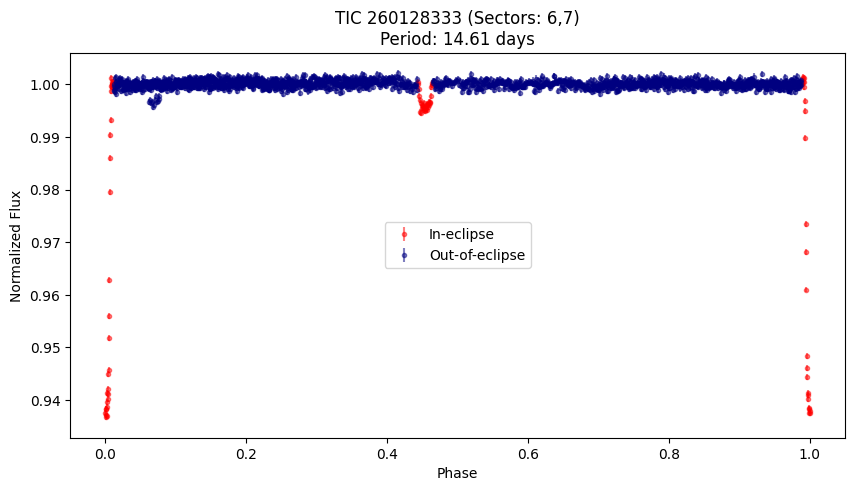

In [7]:
pipeline.plot_bin_phase_fold(tic_id=260128333)

### Detected Events

Plot the detected TCEs for TOI-1338:

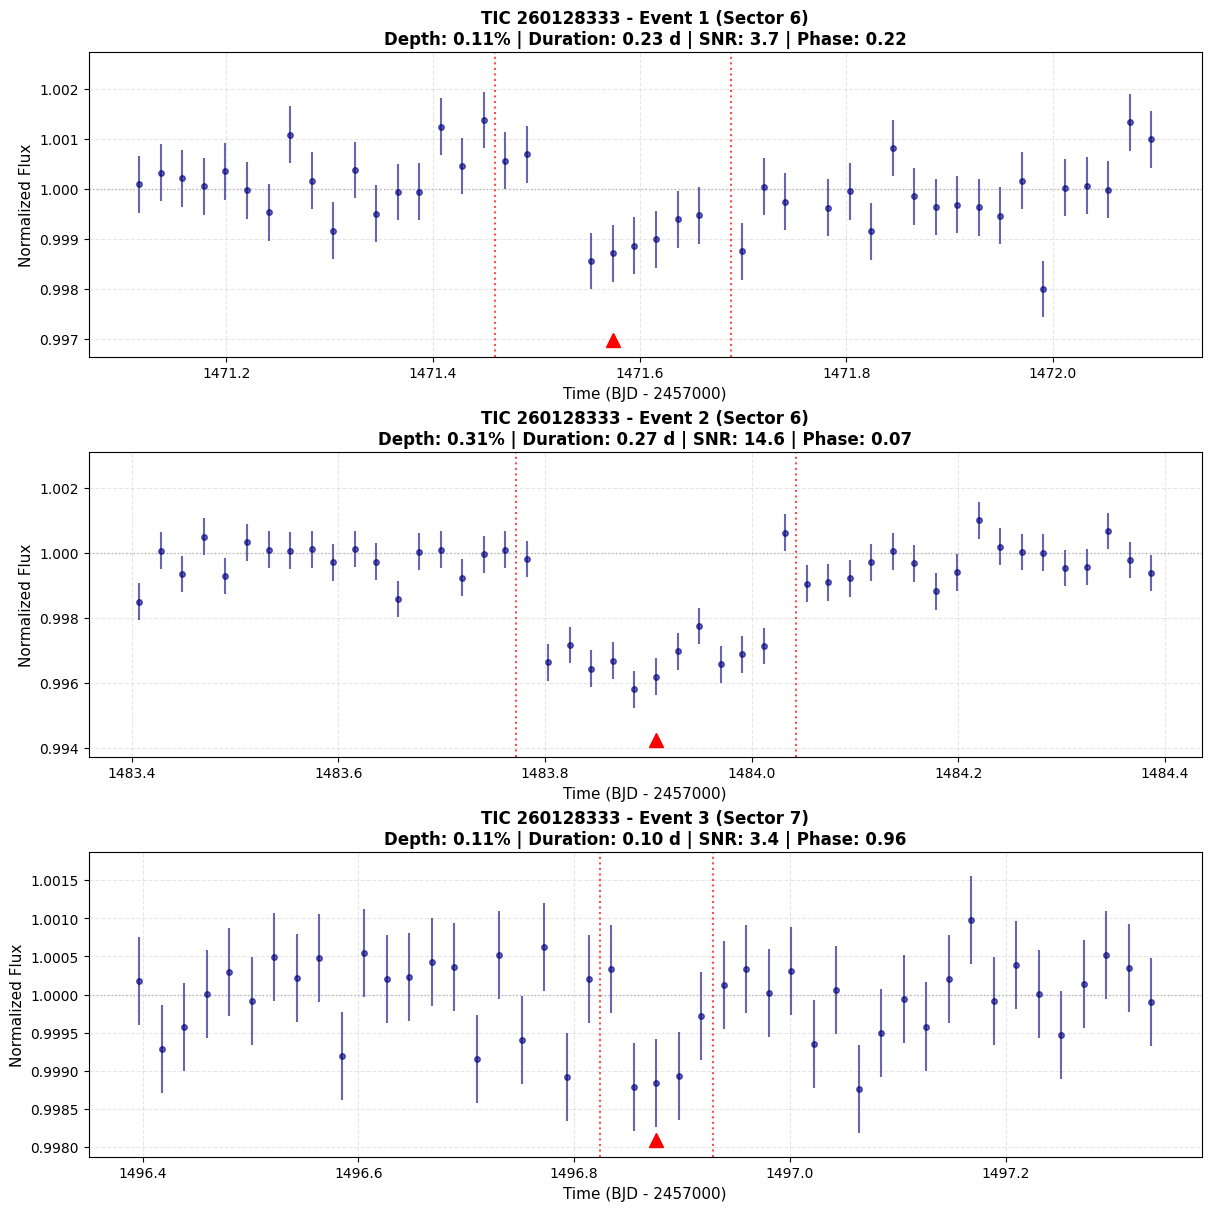

In [8]:
# Plot all detected events for TIC 260128333 (TOI-1338)
pipeline.plot_events(tic_id=260128333)

### Candidate Details

Now let's investigate the model comparison results:

In [9]:
# Display high-confidence candidates (T or AT classifications)
if vetting_df is not None and len(vetting_df) > 0:
    # Filter for high-confidence candidates
    candidates_df = vetting_df[vetting_df['best_fit'].isin(['T', 'AT'])]
    
    if len(candidates_df) > 0:
        print("HIGH-CONFIDENCE CANDIDATES:")
        print("-" * 60)
        
        # Merge with transit data to get event details
        if transit_df is not None:
            for i, row in enumerate(candidates_df.iterrows(), 1):
                idx, candidate = row
                # Extract TIC and sector from filename (format: TIC_XXXXX_S#_event#.npz)
                filename = candidate['filename']
                parts = filename.replace('.npz', '').split('_')
                
                print(f"{i}. {parts[0]} {parts[1]} (Sector {parts[2]}, Event {parts[3]})")
                print(f"   Classification: {candidate['best_fit']}")
                print(f"   AIC - Transit: {candidate['aic_transit']:.1f}")
                print(f"   AIC - Sinusoid: {candidate['aic_sinusoidal']:.1f}")
                print(f"   AIC - Linear: {candidate['aic_linear']:.1f}")
                print(f"   AIC - Step: {candidate['aic_step']:.1f}")
                print(f"   RMSE (Transit): {candidate['rmse_transit']:.2f}")
                print()
        else:
            print(f"Found {len(candidates_df)} high-confidence candidates")
            print("(Transit data not available for details)")
    else:
        print("No high-confidence candidates found.")
        print(f"\nClassification breakdown:")
        print(vetting_df['best_fit'].value_counts())
else:
    print("No vetting results available.")

No vetting results available.


Instead of using `MonoCBPPipeline.run()`, one can perform each of the processing steps individually using the same class. These can then be saved into separate variables.

2025-12-05 04:27:39 - mono_cbp.injection_retrieval - INFO - Starting injection-retrieval tests: 2 injections x 49 models = 98 total tests
2025-12-05 04:27:39 - mono_cbp.injection_retrieval - INFO - Model 1/49: depth=0.0010, duration=0.1000
2025-12-05 04:27:39 - mono_cbp.injection_retrieval - INFO -   Sampling 2 files without replacement from 2 available
2025-12-05 04:27:39 - mono_cbp.utils.detrending - INFO - TIC_260128333_07 cos + biweight
2025-12-05 04:27:39 - mono_cbp.utils.detrending - INFO - Cosine window length: 3.7 days
2025-12-05 04:27:40 - mono_cbp.utils.detrending - INFO - TIC_260128333_06 cos + biweight
2025-12-05 04:27:40 - mono_cbp.utils.detrending - INFO - Cosine window length: 2.1 days
2025-12-05 04:27:41 - mono_cbp.injection_retrieval - INFO -   Model recovery rate: 0.00% (0/2)
2025-12-05 04:27:41 - mono_cbp.injection_retrieval - INFO - Model 2/49: depth=0.0010, duration=0.2500
2025-12-05 04:27:41 - mono_cbp.injection_retrieval - INFO -   Sampling 2 files without replac

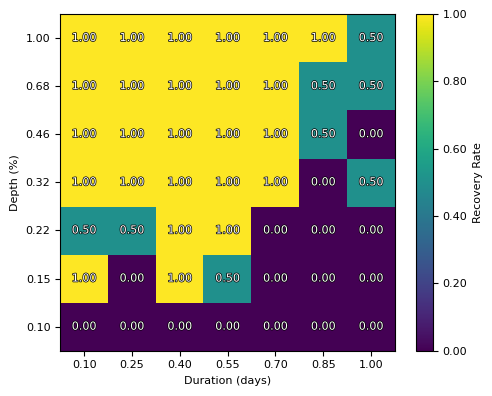

2025-12-05 04:29:08 - mono_cbp.pipeline - INFO - Completeness plot saved


In [ ]:
# Mask eclipses
# Note that there is no returned value from this step,
# the eclipse masks are simply appended onto input data files
pipeline.mask_eclipses()

# Find TCEs
TCE_search = pipeline.find_transits()

# Vet candidates
vetting_results = pipeline.vet_candidates()

# Run injection-retrieval tests
inj_ret_results = pipeline.run_injection_retrieval(plot_completeness=True)